## PCEN Overview

## Setup needed packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import src.conf as conf
import librosa
import librosa.display
from scipy.stats import norm
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Logarithmic versus PCEN
PCEN is a better front-end for denoising natural acoustic data sets because it Gaussianizes the distributions 
of magnitudes while decorrelating frequency bands.  This improves event detection and classification as it
enhances the onset of natural calls while supressing background noise.   
 
First, let's set a few parameters used throughout the notebook

In [8]:
sample_rate = 16000
fmax = 8000  # maximum frequency
window_size = 4096 # fft window size
overlap = 0.5 
hop_length = int(window_size * (1 - overlap))  # convenience as it's used in multiple places

then generate data for an ideal Gaussian curve for comparison

In [9]:
xs_norm = np.arange(-3, 3, 0.001)
ys_norm = norm.pdf(xs_norm, 0, 1)

and finally, define method to display computed results

In [10]:
def display_spec_mag(log_array, pcen_s_array):
    '''
    Displays spectrogram and magnitude distribution grid of log versus pcen arrays
    :param log_array:  numpy array of log computed mel spectrogram array
    :param pcen_s_array:  numpy array of PCEN computed mel spectrogram array
    :return: 
    '''
    fig = plt.figure(constrained_layout=True,  figsize=(10, 10))
    widths = [4, 1]
    heights = [1, 1]
    axes = []
    spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights )
    for row in range(2):
        for col in range(2):
            axes.append(fig.add_subplot(spec[row, col]))
    def normalize(a):
        return (a - a.mean(axis=0)) / a.std(axis=0)
    
    librosa.display.specshow(log_array, x_axis='time', y_axis='mel', ax=axes[0], cmap='Blues', sr=sample_rate,
                             hop_length=hop_length)
    axes[0].set_title('Logarithmic transformation ')
    sns.distplot(normalize(log_array), ax=axes[1])
    axes[1].set_title('magnitude distribution');axes[1].set_xlim(-4, 4); axes[1].set_ylim(0, 0.5)
    axes[1].plot(xs_norm, ys_norm, 'r--', label="Gaussian")
    
    librosa.display.specshow(pcen_s_array, x_axis='time', y_axis='mel', ax=axes[2], cmap='Blues', sr=sample_rate, 
                             hop_length=hop_length)
    axes[2].set_title('Per-channel energy normalization')
    #plt.colorbar(format='%+2.0f dB')
    sns.distplot(normalize(pcen_s_array), ax=axes[3])
    axes[1].set_title('magnitude distribution');axes[3].set_xlim(-4, 4); axes[3].set_ylim(0, 0.5)
    axes[3].plot(xs_norm, ys_norm, 'r--', label="Gaussian")

# Side-by-side comparison
### Load two 5 minutes segments from a wav file representing two different background levels

In [11]:
wav_file=os.path.join(conf.wav_path, conf.target_file_test + '.wav')
samples_A, _ = librosa.load(wav_file, sr=sample_rate, offset=6000, duration=300)
samples_B, _ = librosa.load(wav_file,  sr=sample_rate, offset=7200, duration=300)

# Sound recording sample A
### Compute the spectrogram both for with the log mel transformation and PCEN for sound recording in the first sample A
Note that the librosa PCEN requires data scaled 2e-31 to 2e+31,  not -1 to 1 as is generally the case for many sound files.

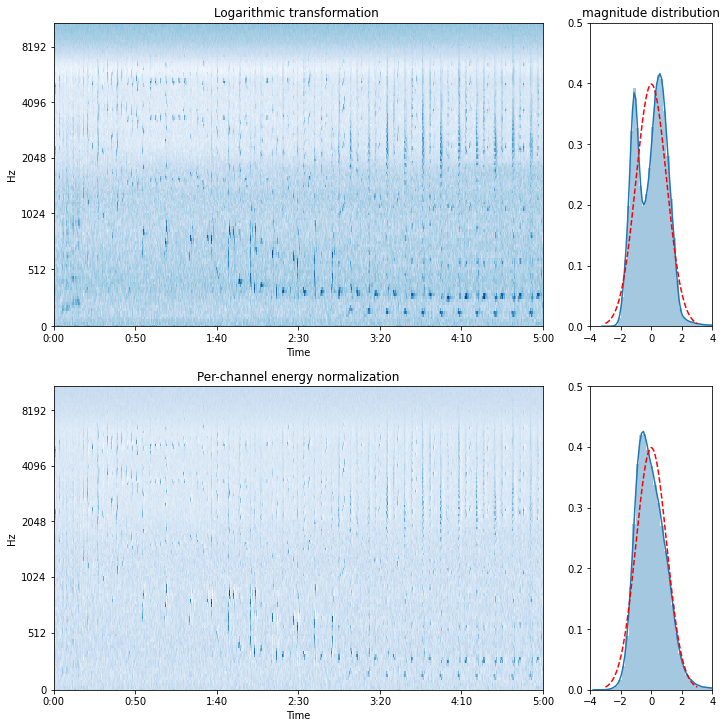

In [6]:
S = librosa.feature.melspectrogram(samples_A, sr=sample_rate, power=1, fmax=fmax, n_fft=window_size, hop_length=hop_length)
log_S_A = librosa.amplitude_to_db(S, ref=np.max)
pcen_S_A = librosa.pcen(S, sr=sample_rate, hop_length=hop_length, gain=0.70, time_constant=0.6, power=0.5, bias=.02, eps=10e-6)
display_spec_mag(log_S_A, (pcen_S_A))

# Sound recording sample B

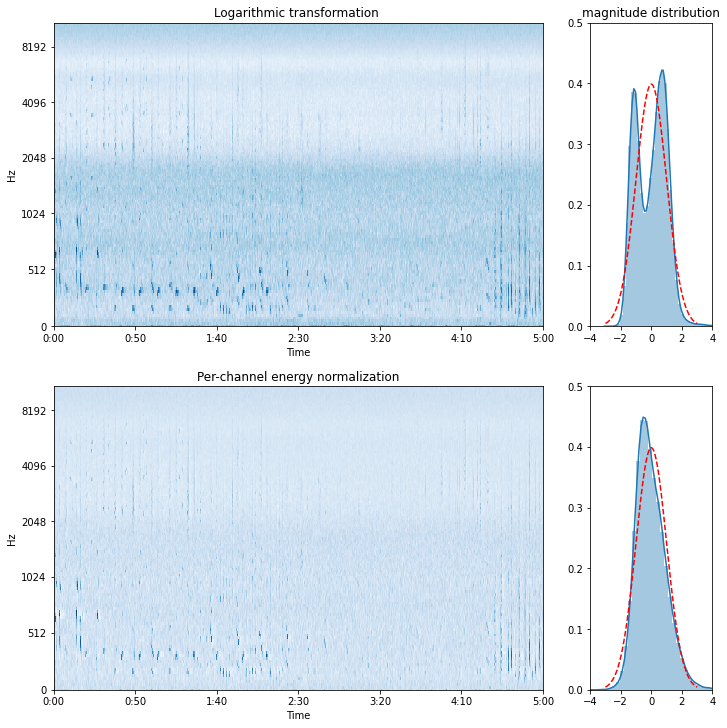

In [7]:
S = librosa.feature.melspectrogram(samples_B, sr=sample_rate, power=1, fmax=fmax, n_fft=window_size, hop_length=hop_length)
log_S_B = librosa.amplitude_to_db(S, ref=np.max)
pcen_S_B = librosa.pcen(S, hop_length=hop_length, gain=0.70, time_constant=0.6, power=0.50, bias=0.02, eps=10e-6)
display_spec_mag(log_S_B, pcen_S_B)